# Texas Housing Time Analysis
__By: Brian Lee__
***

## Business problem:

Housing agents would like to see the next best metropolis to invest in based on the average housing price increases over the last few years. This will allow for the housing agency to better expect price jumps early, allowing for earlier buys at lower prices and selling at higher prices.
Forecast model for TX

As multiple markets like the streaming and tech companies are interested in Texas due to relatively low housing prices and no income tax. 

## Data Preparation

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('time-series/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Extract only Texas data values
TX_df = df[df['State'] == 'TX']
TX_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [4]:
# Houston dataset
houston_df = TX_df[TX_df['Metro'] == 'Houston']

****

We will use __Return on Investment (ROI)__ in order to determine whether the home value in the area is best for the model.

Calculated (Final Value - Initial Value) / Cost of Investment

In [5]:
# 5 year ROI
houston_df['ROI_5_years'] = round((houston_df['2018-04'] - houston_df['2013-01'])/ houston_df['2013-01'],4)

# 3 year ROI
houston_df['ROI_10_years'] = round((houston_df['2018-04'] - houston_df['2008-01'])/ houston_df['2008-01'],4)

houston_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5_years,ROI_10_years
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320200,320400,320800,321200,321200,323000,326900,329900,0.2842,0.2983
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,160200,161900,162800,162800,162800,162900,163500,164300,0.4617,0.2494
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,168400,169600,170900,172300,173300,174200,175400,176200,0.5021,0.2908
22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,140600.0,...,252300,252400,252300,253100,254700,257100,259800,261400,0.4130,0.3189
23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,139200.0,...,250500,250700,251000,251400,251900,253200,255100,256500,0.3783,0.2749


In [6]:
# Reshape from Wide to Long Format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'CountyName', 'ROI_5_years', 'ROI_10_years'], var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
# Remove unnecessary columns
houston_df.drop(columns=['RegionID','State','Metro','SizeRank'], inplace=True)

In [8]:
houston_df.head()

,RegionName,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5_years,ROI_10_years
2,77494,Katy,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,320200,320400,320800,321200,321200,323000,326900,329900,0.2842,0.2983
5,77084,Houston,Harris,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,...,160200,161900,162800,162800,162800,162900,163500,164300,0.4617,0.2494
8,77449,Katy,Harris,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,...,168400,169600,170900,172300,173300,174200,175400,176200,0.5021,0.2908
22,77573,League City,Galveston,141400.0,141000.0,140600.0,140500.0,140400.0,140500.0,140700.0,...,252300,252400,252300,253100,254700,257100,259800,261400,0.4130,0.3189
23,77584,Pearland,Brazoria,138500.0,138700.0,139200.0,139900.0,140700.0,141600.0,142500.0,...,250500,250700,251000,251400,251900,253200,255100,256500,0.3783,0.2749


In [9]:
houston_df.isna().sum().sort_values(ascending=False)

ROI_10_years    0
2003-01         0
2004-03         0
2004-02         0
2004-01         0
               ..
2010-07         0
2010-06         0
2010-05         0
2010-04         0
RegionName      0
Length: 270, dtype: int64

In [10]:
melt_df = melt_data(houston_df)
melt_df.head()

,RegionName,City,CountyName,ROI_5_years,ROI_10_years,Date,value
0,77494,Katy,Harris,0.2842,0.2983,1996-04-01,210400.0
1,77084,Houston,Harris,0.4617,0.2494,1996-04-01,95000.0
2,77449,Katy,Harris,0.5021,0.2908,1996-04-01,95400.0
3,77573,League City,Galveston,0.4130,0.3189,1996-04-01,141400.0
4,77584,Pearland,Brazoria,0.3783,0.2749,1996-04-01,138500.0


In [11]:
melt_df.rename(columns = {"RegionName": "Zipcode", "CountyName": "County", "time": "Date", "value": "Price"}, inplace=True)
melt_df.head()

,Zipcode,City,County,ROI_5_years,ROI_10_years,Date,Price
0,77494,Katy,Harris,0.2842,0.2983,1996-04-01,210400.0
1,77084,Houston,Harris,0.4617,0.2494,1996-04-01,95000.0
2,77449,Katy,Harris,0.5021,0.2908,1996-04-01,95400.0
3,77573,League City,Galveston,0.4130,0.3189,1996-04-01,141400.0
4,77584,Pearland,Brazoria,0.3783,0.2749,1996-04-01,138500.0


In [12]:
# Zipcode type to string
melt_df['Zipcode'] = melt_df['Zipcode'].astype(str)

# 'Date' column to datetime format
melt_df['Date'] = pd.to_datetime(melt_df['Date'], format='%m/%y')

# 'Date' column as dataframe index
melt_df.set_index('Date', inplace=True)

In [13]:
melt_df

,Zipcode,City,County,ROI_5_years,ROI_10_years,Price
Date,,,,,,
1996-04-01,77494,Katy,Harris,0.2842,0.2983,210400.0
1996-04-01,77084,Houston,Harris,0.4617,0.2494,95000.0
1996-04-01,77449,Katy,Harris,0.5021,0.2908,95400.0
1996-04-01,77573,League City,Galveston,0.4130,0.3189,141400.0
1996-04-01,77584,Pearland,Brazoria,0.3783,0.2749,138500.0
...,...,...,...,...,...,...
2018-04-01,77514,Anahuac,Chambers,0.3933,0.2795,136400.0
2018-04-01,77050,Houston,Harris,0.5695,0.2468,115200.0
2018-04-01,77650,Port Bolivar,Galveston,0.2758,0.1968,247500.0


In [14]:
# Double Check for missing values
melt_df.isna().sum()

Zipcode         0
City            0
County          0
ROI_5_years     0
ROI_10_years    0
Price           0
dtype: int64

## EDA and Visualization

__Questions we can ask:__
1. How have Houston housing prices generally trended over time?
2. Which zipcodes in Houston have the highest prices?
3. Which 

### How have Texas housing prices generally trended over time?

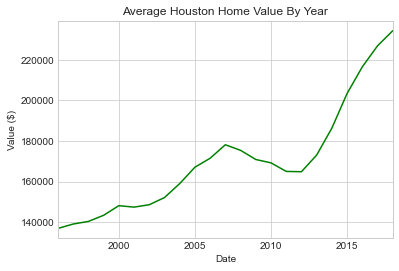

In [15]:
yearly_df = melt_df['Price'].resample(rule='A').mean()
yearly_df.plot.line(color='green')
plt.title('Average Houston Home Value By Year')
plt.ylabel('Value ($)')
plt.show()

* Outside of the dip in housing prices between 2007 and 2011, the average price of a Texas home has __steadily increased__.
***

### Which counties have higher home prices?

In [16]:
county_df = melt_df.copy()
county_df = county_df.groupby('County').Price.mean().sort_values(ascending=False).head(10)

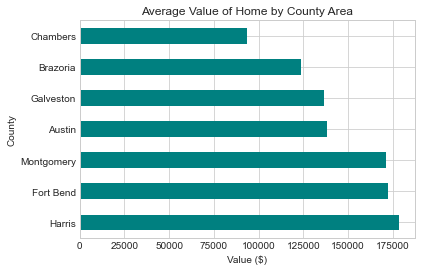

In [17]:
county_df.plot.barh(color='teal')
plt.title('Average Value of Home by County Area')
plt.xlabel('Value ($)')
plt.show()

* __Harris, Fort Bend, and Montgomery__ have clearly the highest average home values in the past 20 years.
___

### Which counties have the highest ROIs?

In [18]:
# 5 year ROI
ROI_5_df = melt_df.copy()
ROI_5_df = ROI_5_df.groupby('County').ROI_5_years.mean().sort_values(ascending=False).head(10)

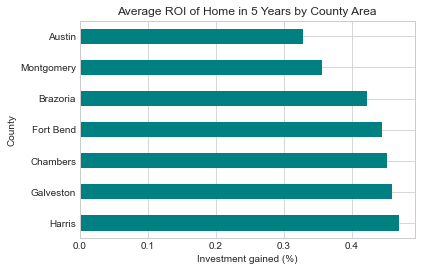

In [19]:
ROI_5_df.plot.barh(color='teal')
plt.title('Average ROI of Home in 5 Years by County Area')
plt.xlabel('Investment gained (%)')
plt.show()

In [20]:
# 10 year ROI
ROI_10_df = melt_df.copy()
ROI_10_df = ROI_10_df.groupby('County').ROI_10_years.mean().sort_values(ascending=False).head(10)

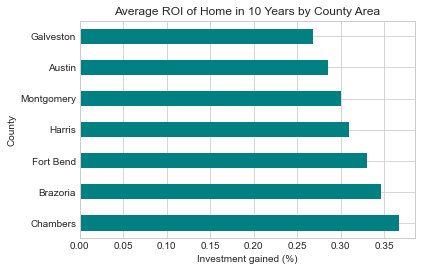

In [21]:
ROI_10_df.plot.barh(color='teal')
plt.title('Average ROI of Home in 10 Years by County Area')
plt.xlabel('Investment gained (%)')
plt.show()

___

### Which Zipcodes in Houston have the highest home prices?

In [22]:
zip_df = melt_df.copy()
zip_df = zip_df.groupby('Zipcode').Price.mean().sort_values(ascending=False).head(10)

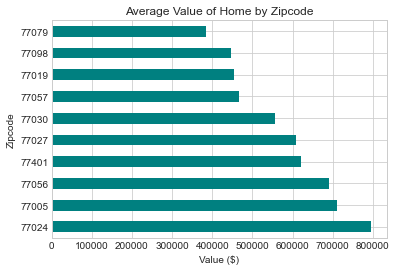

In [23]:
zip_df.plot.barh(color='teal')
plt.title('Average Value of Home by Zipcode')
plt.xlabel('Value ($)')
plt.show()

* __77024__ appears to be the zipcode with the Highest average home value in the past 20 years.
***

In [24]:
zip_df = melt_df.copy()
zip_df = zip_df.groupby('Zipcode').ROI_10_years.mean().sort_values(ascending=False).head(10)

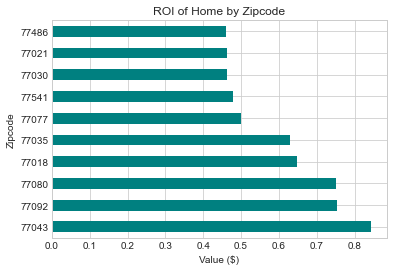

In [25]:
zip_df.plot.barh(color='teal')
plt.title('ROI of Home by Zipcode')
plt.xlabel('Value ($)')
plt.show()

## Time Series Modeling

In [26]:
zip_list = ['77486', '77021', '77030', '77541', '77077', '77035', '77018', '77080', '77092', '77043']

In [27]:
ts = {}
for code in zip_list:
    temp_df = melt_df.groupby('Zipcode').get_group(code).sort_index()['Price']
    ts[code] = temp_df

In [28]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,77486,77021,77030,77541,77077,77035,77018,77080,77092,77043
Date,,,,,,,,,,
1996-04-01,67000.0,45500.0,559900.0,45600.0,177100.0,118800.0,182500.0,107400.0,95600.0,123400.0
1996-05-01,66700.0,45200.0,563500.0,45500.0,180000.0,119700.0,185900.0,106100.0,96900.0,123300.0
1996-06-01,66500.0,44900.0,567200.0,45400.0,182700.0,120900.0,189100.0,105100.0,98400.0,123300.0
1996-07-01,66200.0,44800.0,570900.0,45300.0,185100.0,122300.0,191700.0,104200.0,99900.0,123500.0
1996-08-01,66100.0,44600.0,574500.0,45200.0,187100.0,124100.0,193400.0,103500.0,101500.0,123800.0


Let's start with our first Zipcode

In [29]:
zip_1 = zip_list[0]

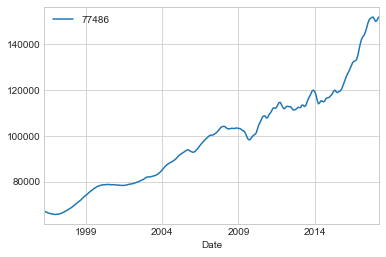

In [34]:
ts = ts_df[zip_1].copy()
ax = ts.plot()
ax.legend()
plt.show()

In [35]:
def plot_autocorr(ts, figsize=(10,8),lags=24):
    
    fig, ax = plt.subplots(nrows=3, figsize=figsize)
    
     ## Plot ts
    ts.plot(ax=ax[0])
    
    ## Plot acf, pacf
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig, ax

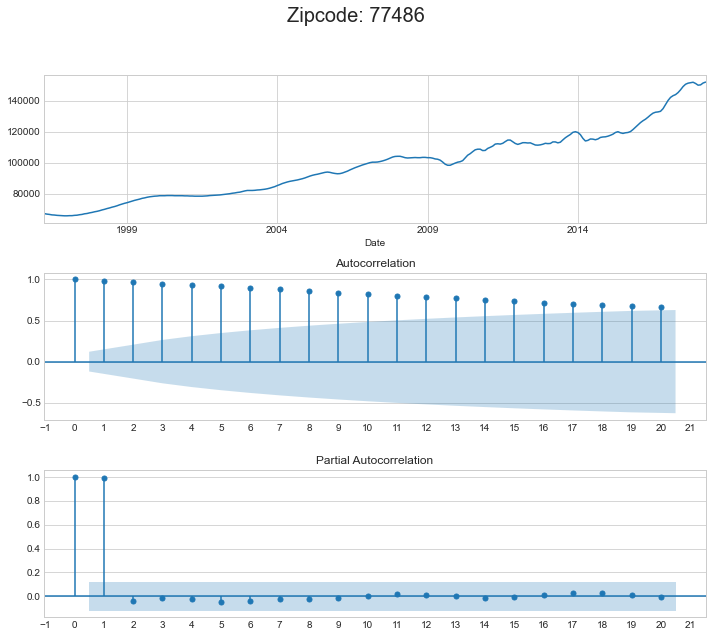

In [36]:
plot_autocorr(ts,lags=20);

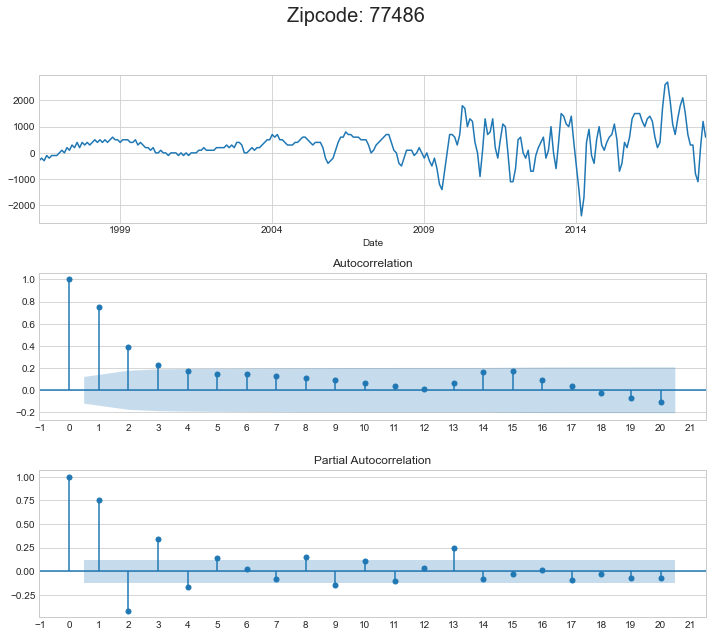

In [37]:
# Let's do a difference to remove trends
d = 1
plot_autocorr(ts.diff(d).dropna(),lags=20);

### Model 1

In [38]:
# selected params
d = 1
p = 1
q = 1

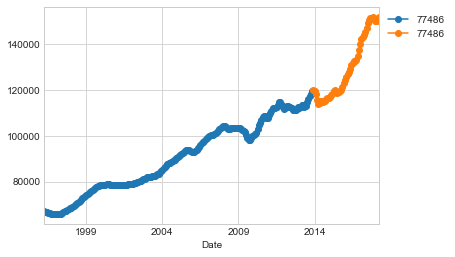

In [39]:
# Train Test Split
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

## Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77486   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1600.990
Date:                Fri, 06 Aug 2021   AIC                           3207.980
Time:                        03:56:51   BIC                           3218.036
Sample:                    04-01-1996   HQIC                          3212.045
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6493      0.052     12.499      0.000       0.548       0.751
ma.L1         -0.4618      0.058     -7.992      0.000      -0.575      -0.349
sigma2      1.672e+05   1.12e+04     14.905      0.000    1.45e+05    1.89e+05
===================================================================================
Ljung-Box (L1) (Q):                  69.61   Jarque-Bera (JB):               354.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

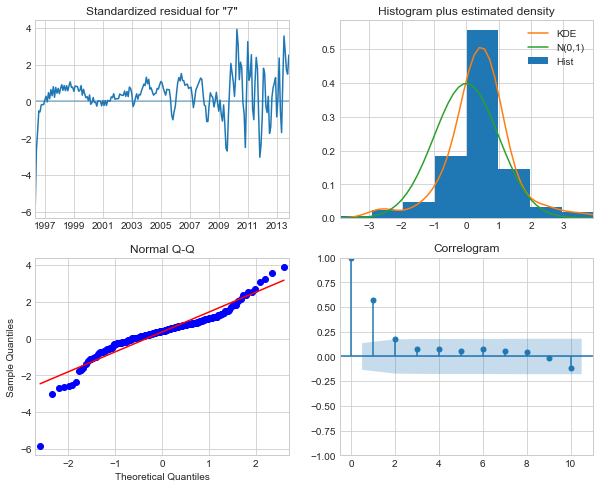

In [48]:
# Baseline model from eye-balled params
model = SARIMAX(train,order=(p,d,q),).fit()
display(model.summary())
model.plot_diagnostics(figsize=(10,8));
plt.show()

In [41]:
# Obtain forecast
from sklearn import metrics
forecast = model.get_forecast(steps=len(test))

In [42]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

In [43]:
pred_df = forecast_to_df(forecast,zip_1)

In [44]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

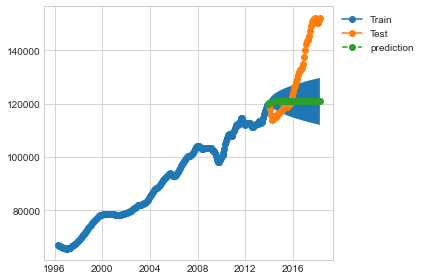

In [45]:
plot_train_test_pred(train,test,pred_df)
plt.show()

### Model 2

In [46]:
!pip install --user pmdarima
import pmdarima as pm
from pmdarima import auto_arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1583.510
Date:                Fri, 06 Aug 2021   AIC                           3173.019
Time:                        03:57:01   BIC                           3183.075
Sample:                             0   HQIC                          3177.084
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.8387     25.951      6.968      0.000     129.975     231.702
ar.L1          0.2309      0.008     27.555      0.000       0.214       0.247
sigma2       1.45e+05   9471.287     15.309      0.000    1.26e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                  61.20   Jarque-Bera (JB):               377.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

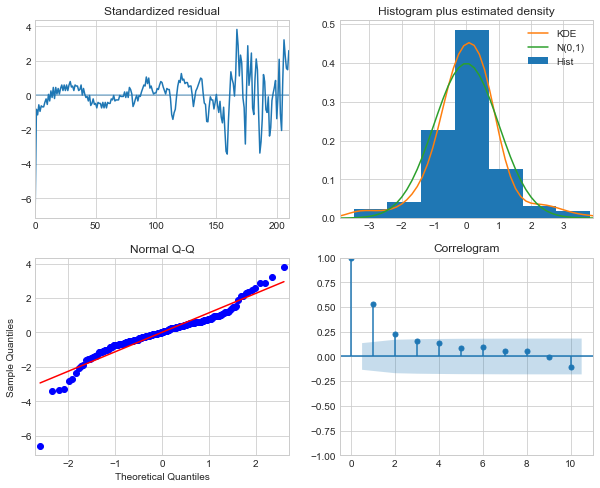

In [49]:
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

### Model 3

C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77486   No. Observations:                  265
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2081.875
Date:                Fri, 06 Aug 2021   AIC                           4167.751
Time:                        03:57:31   BIC                           4174.903
Sample:                    04-01-1996   HQIC                          4170.625
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2651      0.006     45.176      0.000       0.254       0.277
sigma2      2.882e+05   1.82e+04     15.807      0.000    2.52e+05    3.24e+05
===================================================================================
Ljung-Box (L1) (Q):                  71.94   Jarque-Bera (JB):              2542.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

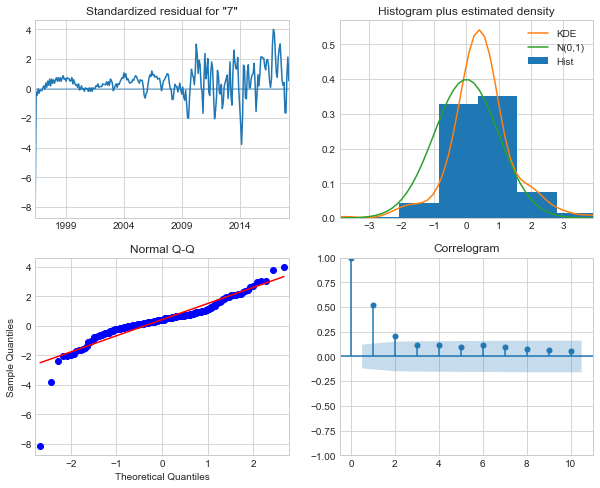

In [50]:
model3 = SARIMAX(ts,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(model3.summary())
model3.plot_diagnostics(figsize=(10,8));

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

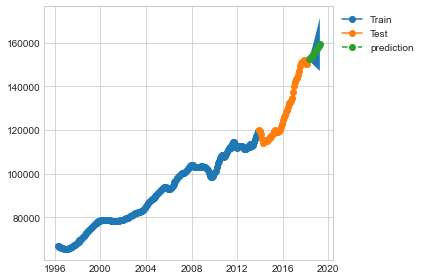

In [57]:
pred = model3.get_forecast(steps=12)
pred_df = forecast_to_df(pred,zip_1)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

77486


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77486   No. Observations:                  265
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1955.294
Date:                Fri, 06 Aug 2021   AIC                           3920.588
Time:                        04:04:06   BIC                           3938.449
Sample:                    04-01-1996   HQIC                          3927.766
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.038     26.352      0.000       0.923       1.071
ar.L2         -0.2951      0.022    -13.594      0.000      -0.338      -0.253
ar.L3          0.1019      0.022      4.585      0.000       0.058       0.145
ma.L1         -0.9489      0.038    -24.815      0.000      -1.024      -0.874
sigma2      1.388e+05   8716.110     15.927      0.000    1.22e+05    1.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.14   Jarque-Bera (JB):                58.35
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

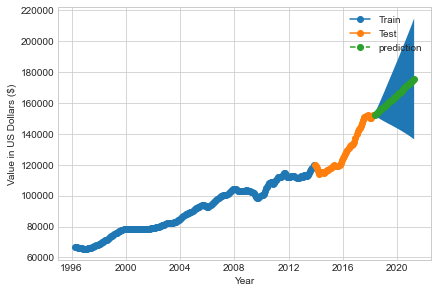

------------------------------------------------------------

77021


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77021   No. Observations:                  265
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -1949.797
Date:                Fri, 06 Aug 2021   AIC                           3905.594
Time:                        04:04:07   BIC                           3916.311
Sample:                    04-01-1996   HQIC                          3909.901
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2115      0.024      8.914      0.000       0.165       0.258
ar.L2         -0.3114      0.017    -18.244      0.000      -0.345      -0.278
sigma2      1.411e+05   7888.838     17.888      0.000    1.26e+05    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                76.05
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               7.77   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

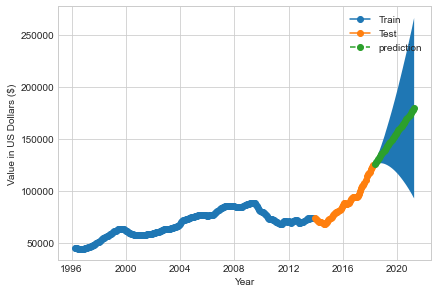

------------------------------------------------------------

77030


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77030   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2287.317
Date:                Fri, 06 Aug 2021   AIC                           4576.635
Time:                        04:04:08   BIC                           4580.207
Sample:                    04-01-1996   HQIC                          4578.071
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.081e+06   1.19e+05     17.486      0.000    1.85e+06    2.31e+06
===================================================================================
Ljung-Box (L1) (Q):                  12.28   Jarque-Bera (JB):                72.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              26.86   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

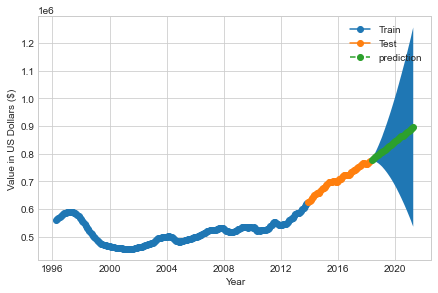

------------------------------------------------------------

77541


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77541   No. Observations:                  265
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1883.498
Date:                Fri, 06 Aug 2021   AIC                           3776.995
Time:                        04:04:10   BIC                           3794.856
Sample:                    04-01-1996   HQIC                          3784.173
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1351      0.054     20.896      0.000       1.029       1.242
ar.L2         -0.5915      0.033    -18.142      0.000      -0.655      -0.528
ar.L3          0.2897      0.036      8.081      0.000       0.219       0.360
ma.L1         -0.9409      0.037    -25.105      0.000      -1.014      -0.867
sigma2      8.091e+04   3707.794     21.820      0.000    7.36e+04    8.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):               808.16
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               5.09   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

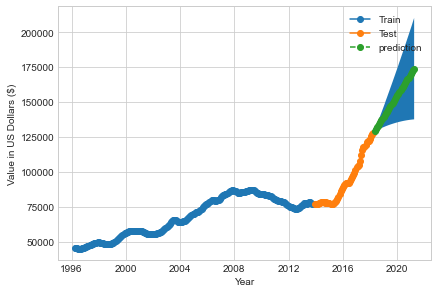

------------------------------------------------------------

77077


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77077   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2033.315
Date:                Fri, 06 Aug 2021   AIC                           4070.630
Time:                        04:04:11   BIC                           4077.774
Sample:                    04-01-1996   HQIC                          4073.501
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0418      0.008      5.362      0.000       0.026       0.057
sigma2      2.954e+05   1.66e+04     17.841      0.000    2.63e+05    3.28e+05
===================================================================================
Ljung-Box (L1) (Q):                  60.48   Jarque-Bera (JB):                89.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.26   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

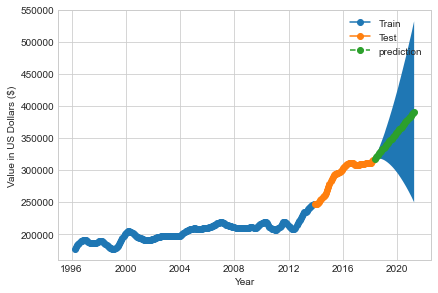

------------------------------------------------------------

77035


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77035   No. Observations:                  265
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -2255.734
Date:                Fri, 06 Aug 2021   AIC                           4523.469
Time:                        04:04:16   BIC                           4544.924
Sample:                    04-01-1996   HQIC                          4532.090
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7267      0.128      5.688      0.000       0.476       0.977
ar.L2          0.0047      0.012      0.400      0.689      -0.019       0.028
ar.L3          0.0064      0.014      0.458      0.647      -0.021       0.034
ar.L4          0.0238      0.014      1.665      0.096      -0.004       0.052
ma.L1         -0.6623      0.129     -5.142      0.000      -0.915      -0.410
sigma2      1.382e+06   3.07e-09    4.5e+14      0.000    1.38e+06    1.38e+06
===================================================================================
Ljung-Box (L1) (Q):                 184.19   Jarque-Bera (JB):               171.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+31. Standard errors may be unstable.
"""

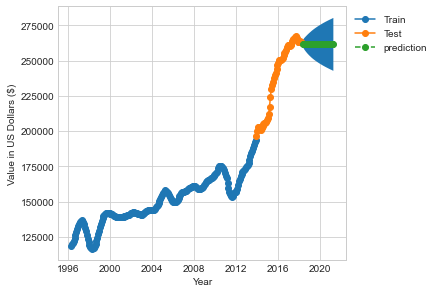

------------------------------------------------------------

77018


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77018   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2427.260
Date:                Fri, 06 Aug 2021   AIC                           4860.519
Time:                        04:04:19   BIC                           4871.247
Sample:                    04-01-1996   HQIC                          4864.830
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.003    385.086      0.000       0.995       1.005
ma.L1         -0.9995      0.028    -35.761      0.000      -1.054      -0.945
sigma2      5.674e+06   7.34e-10   7.73e+15      0.000    5.67e+06    5.67e+06
===================================================================================
Ljung-Box (L1) (Q):                 225.15   Jarque-Bera (JB):                14.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.50
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+31. Standard errors may be unstable.
"""

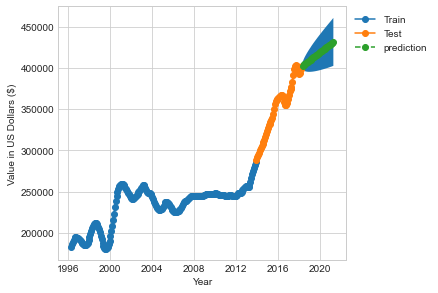

------------------------------------------------------------

77080


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77080   No. Observations:                  265
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -1969.833
Date:                Fri, 06 Aug 2021   AIC                           3951.666
Time:                        04:04:24   BIC                           3973.099
Sample:                    04-01-1996   HQIC                          3960.279
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8751      0.029     64.630      0.000       1.818       1.932
ar.L2         -0.9136      0.027    -34.004      0.000      -0.966      -0.861
ma.L1         -1.8423      0.033    -55.043      0.000      -1.908      -1.777
ma.L2          0.7805      0.046     16.990      0.000       0.690       0.871
ma.L3          0.0911      0.021      4.410      0.000       0.051       0.132
sigma2      1.455e+05   5577.154     26.094      0.000    1.35e+05    1.56e+05
===================================================================================
Ljung-Box (L1) (Q):                  20.10   Jarque-Bera (JB):               443.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.64   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

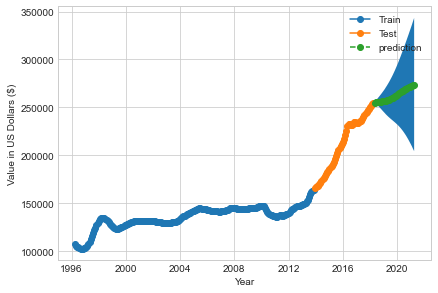

------------------------------------------------------------

77092


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77092   No. Observations:                  265
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -1984.261
Date:                Fri, 06 Aug 2021   AIC                           3974.522
Time:                        04:04:25   BIC                           3985.238
Sample:                    04-01-1996   HQIC                          3978.829
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0731      0.012      6.075      0.000       0.050       0.097
ar.L2         -0.0999      0.011     -8.893      0.000      -0.122      -0.078
sigma2      1.888e+05   1.12e+04     16.853      0.000    1.67e+05    2.11e+05
===================================================================================
Ljung-Box (L1) (Q):                  16.91   Jarque-Bera (JB):                67.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

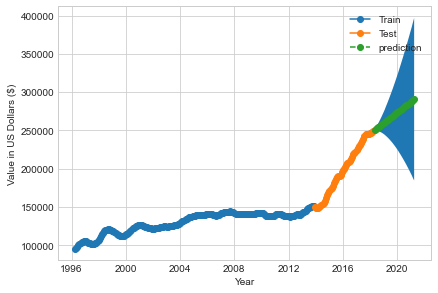

------------------------------------------------------------

77043


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77043   No. Observations:                  265
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -2049.252
Date:                Fri, 06 Aug 2021   AIC                           4106.504
Time:                        04:04:27   BIC                           4120.793
Sample:                    04-01-1996   HQIC                          4112.246
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9426      0.098      9.599      0.000       0.750       1.135
ar.L2         -0.0716      0.014     -5.097      0.000      -0.099      -0.044
ma.L1         -0.8973      0.098     -9.157      0.000      -1.089      -0.705
sigma2      3.275e+05   2.01e+04     16.317      0.000    2.88e+05    3.67e+05
===================================================================================
Ljung-Box (L1) (Q):                  42.77   Jarque-Bera (JB):                74.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.33   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

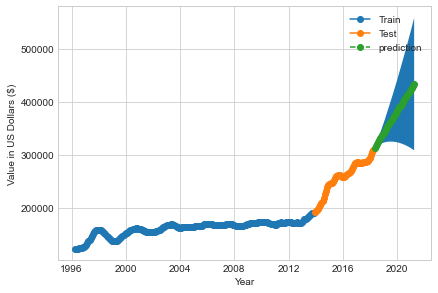

------------------------------------------------------------



In [59]:
RESULTS = {}

for zc in zip_list:
    print(zc)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts_final = ts_df[zc].copy()
    
    ## Train Test Split Index
    train_size = 0.8
    split_idx = round(len(ts)* train_size)

    ## Split
    train = ts_final.iloc[:split_idx]
    test = ts_final.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(ts_final,start_p=0,start_q=0)
    model3 = SARIMAX(ts_final,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = model3.get_forecast(steps=36)
    pred_df = forecast_to_df(pred,zip_1)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = model3
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(model3.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.show()
    
    ## Save district dict in RESULTS
    RESULTS[zc] = zipcode_d
    print('---'*20,end='\n\n')

Best 3 Zipcodes appear to be:
* 77043
* 77018
* 77541

Looking at the models, they have the a less chance of decline with still great possibilities of the home price increasing.

# Step 6: Interpreting Results